# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import copy

from stroke_outcome.continuous_outcome import Continuous_outcome

In [2]:
# Set up MatPlotLib
%matplotlib inline

In [3]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

## Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

| Centre | x | y |
| --- | --- | --- |
| IVT | 0 | 0 |
| IVT/MT | 0 | $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$ |

In [4]:
travel_ivt_to_mt = 50

In [5]:
ivt_coords = [0, 0]
mt_coords  = [0, -travel_ivt_to_mt]

Change these parameters:

In [6]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [7]:
def make_time_grid(
        xy_max,
        step,
        x_offset=0,
        y_offset=0
    ):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [32]:
grid_time_travel_directly_to_ivt = make_time_grid(
    grid_xy_max,
    grid_step,
    x_offset=ivt_coords[0], 
    y_offset=ivt_coords[1]
)

In [33]:
grid_time_travel_directly_to_mt = make_time_grid(
    grid_xy_max,
    grid_step,
    x_offset=mt_coords[0],
    y_offset=mt_coords[1]
)

In [34]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [35]:
extent = [
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5,
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5
]

## Plot travel time grids

Setup for plots:

In [36]:
titles = [
    'Travel time'+'\n'+'directly to IVT centre', 
    'Travel time'+'\n'+'directly to MT centre', 
    'Difference in travel time'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Travel time (mins)', 
    'Difference in travel time (mins)'
    ]

Import this function to make the plots:

In [37]:
from outcome_utilities.geography_plot import plot_two_grids_and_diff

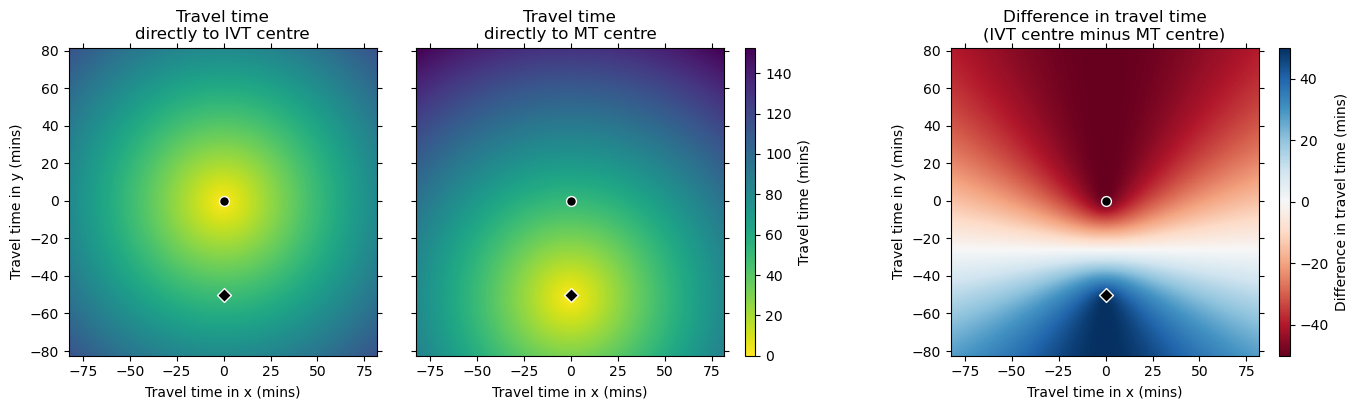

In [38]:
plot_two_grids_and_diff(
    grid_time_travel_directly_to_ivt, 
    grid_time_travel_directly_to_mt, 
    grid_time_travel_directly_diff,
    titles=titles,
    cbar_labels=cbar_labels, 
    extent=extent,
    cmaps=['viridis_r', 'RdBu'],
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )

On the difference grid, positive values are nearer the IVT/MT centre and negative nearer the IVT-only centre. There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably the curves in the difference grid match the ones drawn in the Holodinsky et al. 2017 paper.__

## Plot travel time circles

To help define colour limits (`vmin` and `vmax`), gather the coordinates within the largest flattened radiating circle:

In [39]:
from outcome_utilities.geography_plot import find_mask_within_flattened_circle

In [88]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max
)

coords_valid = np.where(grid_mask<1)

In [41]:
vmin_time = np.nanmin(-grid_time_travel_directly_diff[coords_valid])
vmax_time = np.nanmax(-grid_time_travel_directly_diff[coords_valid])

Update plotting style:

In [42]:
time_step_circle = 5
circ_linewidth = 0.5

In [43]:
from outcome_utilities.geography_plot import circle_plot

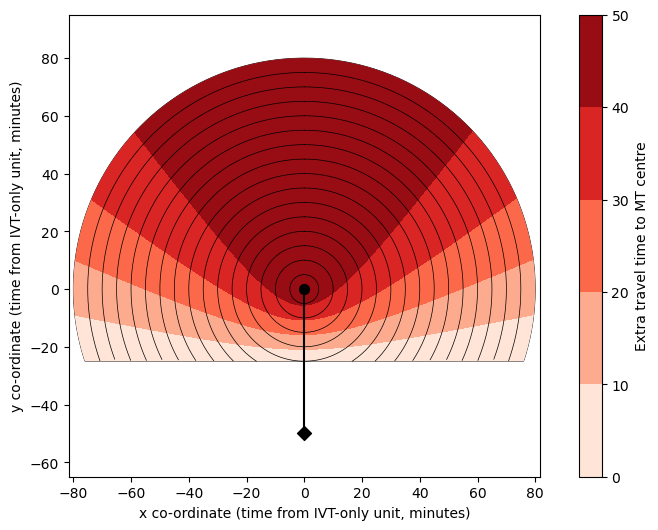

In [44]:
circle_plot(
    -grid_time_travel_directly_diff,
    travel_ivt_to_mt, 
    time_travel_max,
    time_step_circle,
    vmin_time,
    vmax_time,
    imshow=0, 
    cbar_label='Extra travel time to MT centre',
    extent=extent,
    ivt_coords=ivt_coords,
    mt_coords=mt_coords,
    cmap='Reds',
    n_contour_steps=5,
    circ_linewidth=circ_linewidth,
    )

## Feed time grid into the outcome model

For simplicity, we'll just show a basic example here.

We'll calculate some times to thrombectomy by adding a fixed time to the travel time grids.

In [45]:
extra_pathway_time = 42  # minutes

Time to treatment when a transfer between centres is required:

In [46]:
grid_time_mt_centre1_centre2 = (
    grid_time_travel_directly_to_ivt + travel_ivt_to_mt + extra_pathway_time
)

Time to treatment when the MT centre was travelled to directly:

In [47]:
grid_time_mt_centre2 = (
    grid_time_travel_directly_to_mt + extra_pathway_time
)

Flatten the grids into columns of data and create the other inputs for the outcome model.

In [48]:
df_mt_centre1_centre2 = pd.DataFrame()
df_mt_centre1_centre2['onset_to_puncture_mins'] = grid_time_mt_centre1_centre2.flatten()
df_mt_centre1_centre2['onset_to_needle_mins'] = 0.0
df_mt_centre1_centre2['stroke_type_code'] = 2
df_mt_centre1_centre2['ivt_chosen_bool'] = 0
df_mt_centre1_centre2['mt_chosen_bool'] = 1

In [49]:
df_mt_centre2 = pd.DataFrame()
df_mt_centre2['onset_to_puncture_mins'] = grid_time_mt_centre2.flatten()
df_mt_centre2['onset_to_needle_mins'] = 0.0
df_mt_centre2['stroke_type_code'] = 2
df_mt_centre2['ivt_chosen_bool'] = 0
df_mt_centre2['mt_chosen_bool'] = 1

Set up the outcome model:

In [50]:
# Set up outcome model
outcome_model = Continuous_outcome()

In [51]:
dfs = [df_mt_centre1_centre2, df_mt_centre2]

for df in dfs:
    outcome_model.assign_patients_to_trial(df)
    
    # Calculate outcomes:
    patient_data_dict, outcomes_by_stroke_type, full_cohort_outcomes = (
        outcome_model.calculate_outcomes())
    
    # Make a copy of the results:
    outcomes_by_stroke_type = copy.copy(outcomes_by_stroke_type)
    full_cohort_outcomes = copy.copy(full_cohort_outcomes)
    
    # Place the relevant results into the starting dataframe:
    df['added_utility'] = full_cohort_outcomes['each_patient_utility_shift']
    df['mean_mrs'] = full_cohort_outcomes['each_patient_mrs_post_stroke']
    df['mrs_less_equal_2'] = full_cohort_outcomes['each_patient_mrs_dist_post_stroke'][:, 2]
    df['mrs_shift'] = full_cohort_outcomes['each_patient_mrs_shift']

Calculate difference grid:

In [52]:
df_mt_diff = df_mt_centre1_centre2 - df_mt_centre2

### Plot the outcomes

Setup:

In [53]:
outcome_col = 'added_utility'
cmap = 'plasma'

titles = [
    'Added utility for LVO with MT'+'\n'+'Transfer from IVT centre', 
    'Added utility for LVO with MT'+'\n'+'Directly to MT centre', 
    'Difference in added utility'+'\n'+'(transfer minus direct)'
    ]

cbar_labels = [
    'Added utility', 
    'Difference in added utility'
    ]

Plot grids:

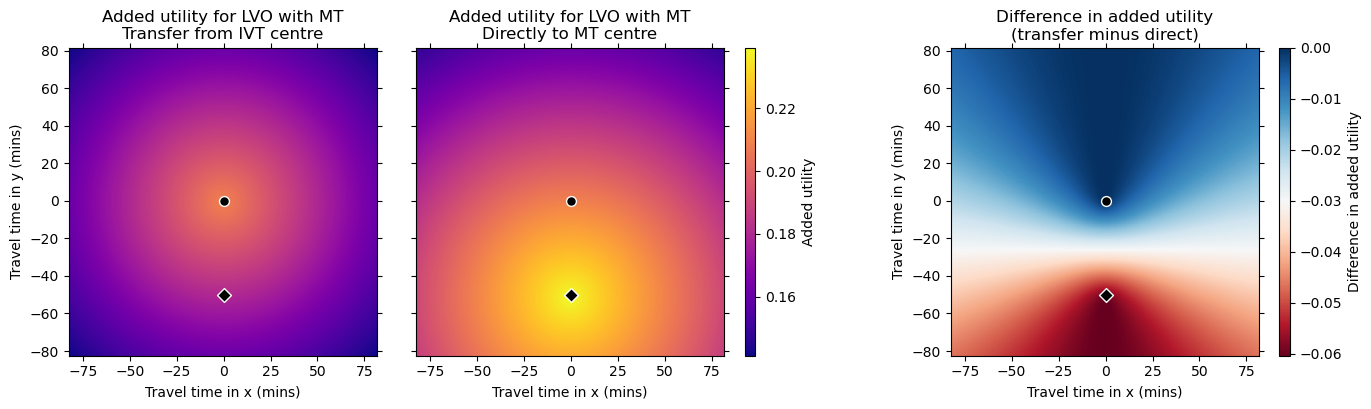

In [54]:
plot_two_grids_and_diff(
    df_mt_centre1_centre2[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape),
    df_mt_centre2[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape),
    df_mt_diff[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape),
    titles=titles,
    cbar_labels=cbar_labels, 
    extent=extent,
    cmaps=[cmap, 'RdBu'],
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )

Plot circles:

Use the same grid mask and so valid coordinates from the travel time circle plot earlier.

In [98]:
vmin = np.nanmin(-df_mt_diff[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape)[coords_valid])
vmax = np.nanmax(-df_mt_diff[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape)[coords_valid])

Update plotting style:

In [100]:
time_step_circle = 5
circ_linewidth = 0.5

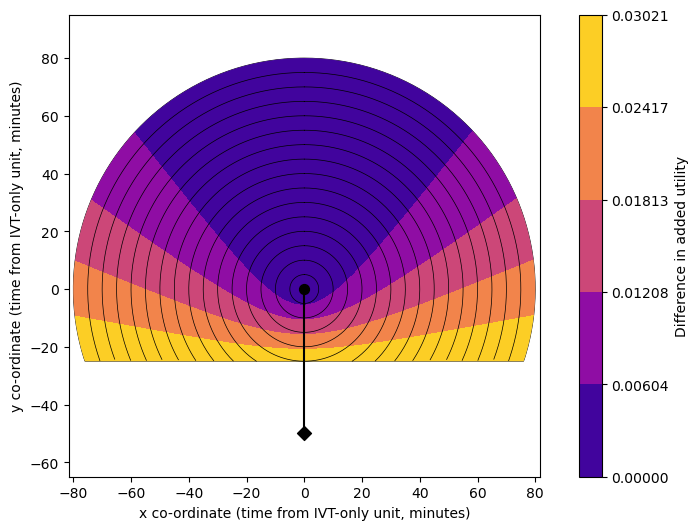

In [101]:
circle_plot(
    -df_mt_diff[outcome_col].values.reshape(grid_time_mt_centre1_centre2.shape),
    travel_ivt_to_mt, 
    time_travel_max,
    time_step_circle,
    vmin,
    vmax,
    imshow=0, 
    cbar_label='Difference in added utility',
    extent=extent,
    ivt_coords=ivt_coords,
    mt_coords=mt_coords,
    cmap='plasma',
    n_contour_steps=5,
    circ_linewidth=circ_linewidth,
    )